# Opinion Training School: Automated Image and Video Data Analysis with Python

## _Elbasan (May 29, 2025)_

### Instructor:

### Dr. Felicia Loecherbach (University of Amsterdam)


---
---


# Supervised Classification

<ins>**Objectives:**</ins>

- **load and implement pre-trained CNN**: you'll learn how to load and use a
  pre-trained CNN to generate class/image predictions on your images.

- **fine-tune a pre-trained CNN**: you'll learn how to fine-tune a pre-trained
  CNN to perform a new task of interest to you.

<ins>**Datasets:**</ins>

- **world leaders dataset**: a dataset with sample open source images for 5
  world leaders that Nora Webb Williams and Andreu Casas put together a while
  back.

- **protest dataset**: a dataset with sample images of street protests, related
  to BLM protests (and images that are not of protests), that also Nora Webb
  Williams and Andreu Casas put together.

<ins>**Key module/s:**</ins>

- **PyTorch**: there are many deep learning library/modules for python (e.g.
  keras, pytorch, tensorflow). I started using PyTorch a while back. Back then
  they made it very easy to e.g. use open-source pre-trained models and modify
  the architecture of those models. These days all these libraries have really
  good and similar functionalities. I'll stick to pytorch in these tutorials,
  but any of these libraries would do the trick.


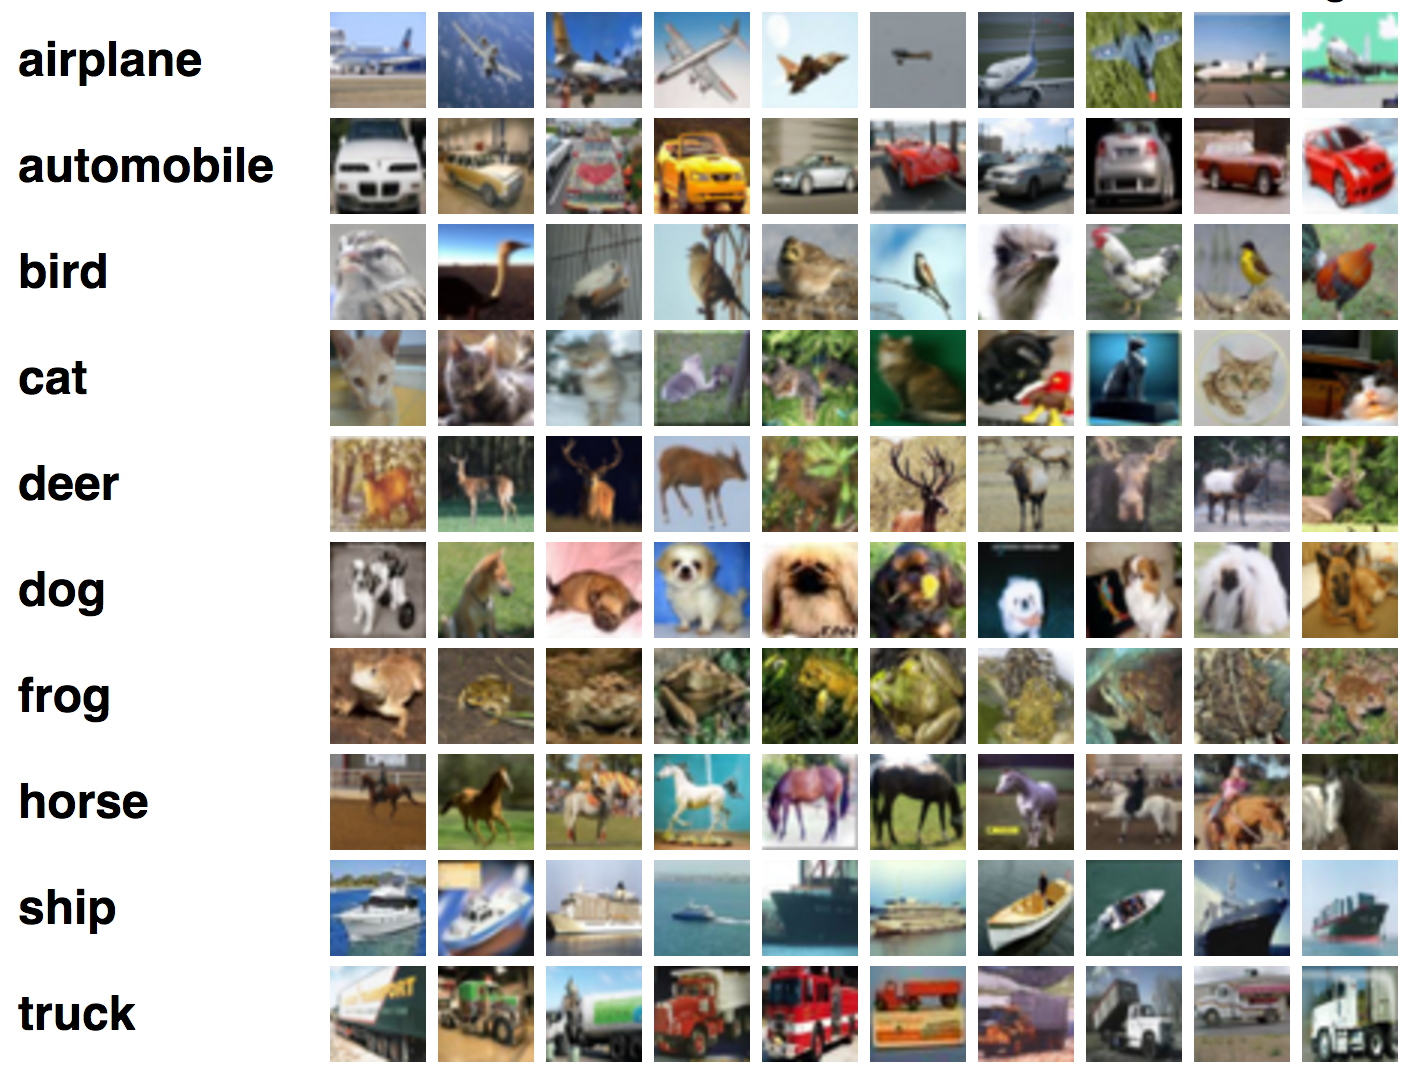


---
---


## 0. Install the packages/modules that we'll be using. Set up GPU.

These google-colab notebooks allow us to run code in virtual machines located
elsewhere. Every time we start a session, the virtual machine is "empty", so
non-native python modules need to be installed. Let's install the ones we'll
need in this particular notebook. We'll do so using `pip` and the `!` marker
that allows us to run `bash` code in the same notebook.


In [1]:
# - before getting started, set up GPU.
import torch

# - the device name should look like the following:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available.")

GPU is not available.


## 1. Load the modules that we'll be using


In [ ]:
from google.colab import drive # module to mount the google drive
import os
from PIL import Image
import json
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 4.4 MB/s eta 0:00:00


In [ ]:
# - install clip, one of the models we'll be using in the workshop
!pip install git+https://github.com/openai/CLIP.git

In [ ]:
# - load datasets package, used for creating Huggingface type datasets
!pip install datasets

In [ ]:
!pip install git+https://github.com/huggingface/peft.git

In [ ]:
# - install a package that we'll use for quantization (reducing the size of weights of the VLM Idefics2)
!pip install bitsandbytes

In [ ]:
# - pytorch for deep learning modeling
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from sklearn.metrics import precision_score, recall_score
import timm
from torch.utils.data import DataLoader
# - pytorch for deep learning modeling
from tqdm import tqdm
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import clip
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import re # regular expression pacakge
from datasets import Dataset
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training


## 2. Mount the Google Drive for the workshop to this virtual machine


In [ ]:
# - it will generate a url. Click on it, specify the google account you want to
#   use, and
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## 3. Declare the data path


In [ ]:
data_path = '/content/gdrive/MyDrive/images-as-data-workshop-elbasan/data/'
out_dir = '/content/gdrive/MyDrive/images-as-data-workshop-elbasan/output/'

## 4. Load a pre-trained model and perform zero-shot classfication

`PyTorch` make it very easy to load and use CNN models that have been trained on
huge datasets and perform very very well at predicting a specific set of
image-classes/objects (e.g. car, truck, chair, horse, person, etc.). Let's first
learn how to load these pre-trained models using pytorch, and then use the model
to classify some sample images (what's commonly known as zero-shot
classification).


In [ ]:
# - load pre-trained image model: Resnet50.
model = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V2')

# - set up the model to "evaluation" mode: so to avoid the model for training
#   further and the weights to be updated. We only want to generate predictions.
model.eval()

# - activate the GPU option, to make sure we're using it
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# - load an image to use for testing
img_path = '{}dog.jpeg'.format(data_path)
img = Image.open(img_path).convert('RGB')

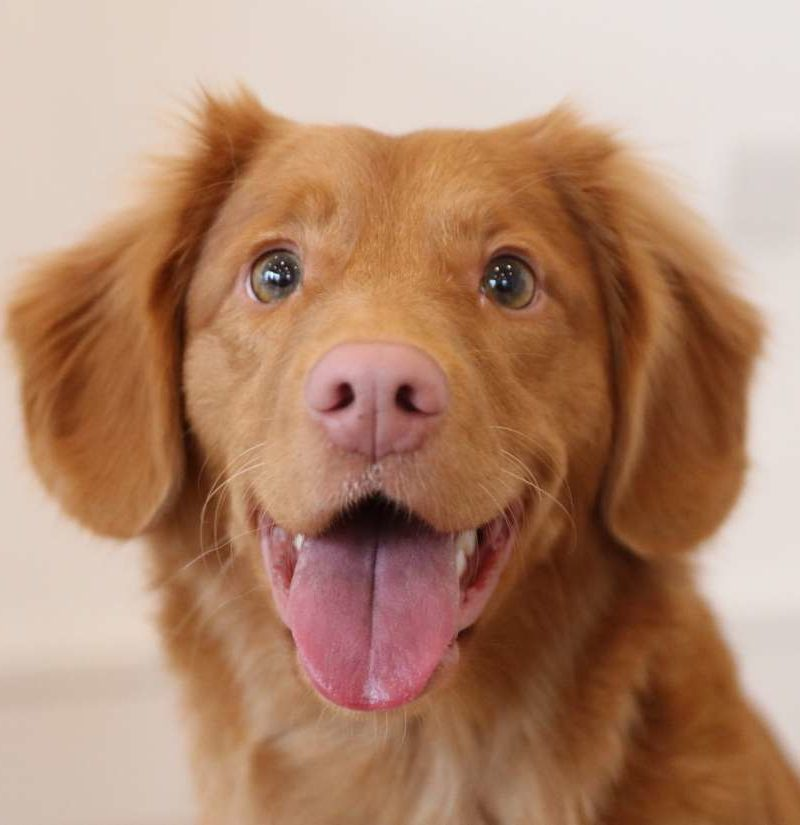

In [ ]:
img

In [ ]:
def data_transform(train=True, mean=[0.485, 0.456, 0.406],
                   sd=[0.229, 0.224, 0.225], scale=256, random_crop=224):
    """
    Description: This function creates an object to transform train and
        test (or only testing) images.
    Parameters:
        `train`: type <bool> indicating if the object will need to be used
                    to transform training and testing images (=True) or
                    only testing.
        `mean`: type <list> of 3 floats indicating the mean value of the 3 RGB
                    image inputs.
        `sd`: type <list> of 3 floats indicating the standard deviation of
                    the 3 RGB mean inputs.
        `scale`: type <int> indicating the new size to give to the train and
                    test data (e.g. 256x256 pixel images).
        `random_crop`: type <int> indicating the size of the part of the image
                    really used for training-testing (e.g. 224x224)
    Output:
        An object to be used for preprocessing the train and test images
    """
    common_transforms = [
        # Resize the image to the specified scale
        transforms.Resize(scale),
        # Center crop the image to the specified size
        transforms.CenterCrop(random_crop),
        # Convert the image to a tensor
        transforms.ToTensor(),
        # Normalize the image with the specified mean and standard deviation
        transforms.Normalize(mean, sd)
    ]

    if train:
        train_transforms = [
            # Randomly crop the image to the specified size
            transforms.RandomResizedCrop(random_crop),
            # Randomly flip the image horizontally
            transforms.RandomHorizontalFlip()
        ]
        data_transforms = {
            # Combine train-specific and common transforms
            'train': transforms.Compose(train_transforms + common_transforms),
            # Use only common transforms for testing
            'test': transforms.Compose(common_transforms)
        }
    else:
        # Use only common transforms if not training
        data_transforms = transforms.Compose(common_transforms)

    return data_transforms

In [ ]:
# initialize the data_transform object that we'll use to pre-process the image
pre_processor = data_transform(train = False)

# initialize a softmax function that we'll use for generating Prob. predictions
softmax = torch.nn.Softmax(dim = 0)

In [ ]:
# ... preprocess/normalize the image
img_transformed = Variable(pre_processor(img).unsqueeze(0))
# ... model predictions
model_out = model(img_transformed.cuda()).cpu()

In [ ]:
# ... from logits to predicted Pr.
pred_probs = softmax(model_out[0])

In [ ]:
# ... pull the maximum predicted pr and class
max_pr, max_class = torch.max(pred_probs, dim = 0)
print('Max Class: {} | Max Pr: {}'.format(max_class, max_pr))

Max Class: 215 | Max Pr: 0.4031156897544861


In [ ]:
# - what is the class #215? How can we find out? A list of the 1,000 ImageNet
#   class number and label can be found e.g. here:
#   https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

# - I already saved a copy of this file in our data directory. Let's load it
#   and look up the class label for 215
labels = json.load(open('{}imagenet_class_index.json'.format(data_path, 'rb')))

In [ ]:
labels['215']

['n02101388', 'Brittany_spaniel']

In [ ]:
# - feel free to take a look at the 1,000 classes of the ImageNet dataset. Most
#   of these pre-trained models are trained on this data -- and so predict the
#   same 1,000 classes
labels

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

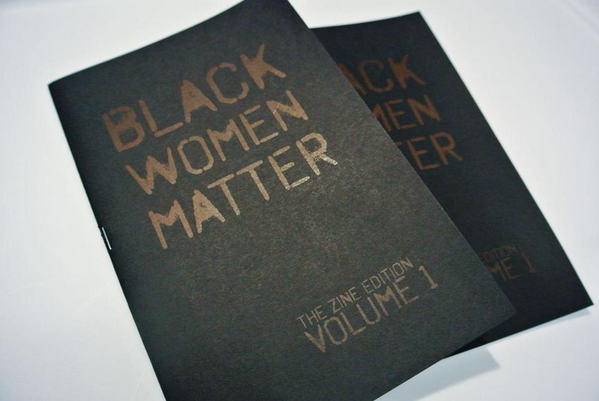

In [ ]:
# - let's try the same thing with this other image
img_path = '{}protest/train/negative/55572.jpg'.format(data_path)
img = Image.open(img_path).convert('RGB')
img

In [ ]:
# ... preprocess/normalize the image
img_transformed = Variable(pre_processor(img).unsqueeze(0))
# ... model predictions
model_out = model(img_transformed.cuda()).cpu()
# ... from logits to predicted Pr.
pred_probs = softmax(model_out[0])
# ... pull the maximum predicted pr and class
max_pr, max_class = torch.max(pred_probs, dim = 0)
print('Max Class: {} | Max Pr: {} | Label: {}'.format(
    max_class, max_pr,
    labels[str(max_class.numpy())][1]))

Max Class: 539 | Max Pr: 0.3284355103969574 | Label: doormat


## 5. Fine-tuning a pre-trained model

A pre-trained model may do poorly in classifying images into some classes of
interest to us. If that's the case, we can try to leverage the many things the
model has already learned by being trained on millions on images, but then adapt
it to our particular classification task. To do so, we'll need to:

- (a) adapt the model architecture, by replacing the final fully connected layer
  for a layer that fits our classification task (so predicting e.g. 2 rather
  1,000 classes)
- (b) train the pre-trained model for a few more iterations

We'll now practice how to do this by fine-tuning a pre-trained model to predict
a binary outcome: whether an image is of a street **protest**. In order to do
so, we have already **collected** and **annotated** some data for our quantity
of interest (so we have some images we know are of street protests and some
images we know are not).

### Data structure

Here a look at how your data needs to be set up to fit the requirements of the
`ImageFolder` and `DataLoader` utilities in pytorch.

- `root-data-folder`
  - `train`
    - `class-label`
      - `img`
      - `img`
      - ...
    - `class-label`
      - `img`
      - `img`
      - ...
    - ...
  - `test`
    - ...
      - ...
  - `val`
    - ...
      - ...

Here for example how it's set up for the data we'll now use to fine-tune the
model to predict images of street protests.

- `protest`
  - `train`
    - `negative`
      - `img`
      - `img`
      - ...
    - `positive`
      - `img`
      - `img`
      - ...
  - `test`
    - `negative`
      - `img`
      - `img`
      - ...
    - `positive`
      - `img`
      - `img`
      - ...


In [ ]:
# - load a pre-trained model: e.g. Resnet50
model = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')

In [ ]:
# - specifying HYPERPARAMETERS (researcher's choice! Some rules of thumb, but
#   usually you should perform a grid search --try many setups-- to see which
#   particular hyperparameter configuration works best)

# - specify the new number of outcome classes: 2 (binary: protest | not-protest)
num_classes = 2

# - how often do you want the loop to print information about model performance
report_num = 1 # ... every iteration

# - hyperparameters
# Learning rate: How much to adjust the model
# with respect to the error each time the model weights are updated
set_learn_rate = 0.0001
# Momentum: Helps accelerate gradients
# vectors in the right directions, thus leading to faster converging
set_momentum = 0.9
# Step size: Number of epochs after which the learning rate is adjusted
set_step_size = 7
# Gamma: Multiplicative factor for learning rate decay
set_gamma = 0.1
# Number of iterations: How many times the entire dataset is passed through the model
iter_num = 10
# Batch size: Number of samples processed before the model is updated
set_batch_size = 4

In [ ]:
# Loss function: Measures the difference between the predicted output and the actual output
criterion = nn.CrossEntropyLoss()
# Optimizer: Adjusts the model parameters to minimize
# the loss function using Stochastic Gradient Descent (SGD)
optimizer = optim.SGD(model.parameters(),
                         lr=set_learn_rate,
                         momentum=set_momentum)
# Learning rate scheduler: Adjusts the learning rate at regular intervals
# (step size) by multiplying it with a factor (gamma)
scheduler = lr_scheduler.StepLR(optimizer,
                                       step_size=set_step_size,
                                       gamma=set_gamma)

In [ ]:
# - check number of features in last fully connected layer
num_ftrs = model.fc.in_features

# - change the output layer from 1,000 classes to a binary outcome
model.fc = nn.Linear(num_ftrs, num_classes) # For ResNet50, last step is 2048 -> 2

In [ ]:
# - initialize preprocessing object
preprocess = data_transform()

In [ ]:
# - specify the path to data for this particular classifier
model_path = '{}protest/'.format(data_path)

# - specifying where the train and test images are
image_datasets = {x: datasets.ImageFolder(os.path.join(model_path, x),
                                          preprocess[x]) for x in ['train', 'test']}

# - creating an object to easily load the train and test images
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=set_batch_size,
                                             shuffle=True)
              for x in ['train', 'test']}

# - getting some extra information such as the size of the dataset and the
#       class number
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

# - making sure again that we're using GPU. Also, taking the opportunity to check
#   the model architecture and making sure that the "prediction head" has been
#   replaced and is now set up to predict a binary outcome.
use_gpu = True # /!\ Set to False if you run it in a machine with no GPUs
if use_gpu:
  model.cuda()

#### Model Training/Fine-tuning


In [ ]:
# Initialize variables
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
since = time.time()
best_model_wts = model.state_dict()  # Save the initial model weights
best_acc = best_precision = best_recall = 0.0
loss_progress, acc_progress = [], []

# Training loop
for iteration in range(iter_num):
    if iteration % report_num == 0:
        print(f'Iteration {iteration + 1}/{iter_num}')
        print('-' * 10)

    for phase in ['train', 'test']:
        # Set the model to training mode if phase is 'train', else set to evaluation mode
        model.train(phase == 'train')

        # Initialize running metrics
        running_loss = 0.0
        running_corrects = 0
        running_preds = []
        running_labels = []

        # Iterate over data
        for data in dataloaders[phase]:
            inputs, labels = data
            # Move data to GPU if available
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass: compute the model output
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)  # Get the class with the highest score
            loss = criterion(outputs, labels)  # Compute the loss

            # Backward pass and optimize only if in training phase
            if phase == 'train':
                loss.backward()  # Compute the gradients
                optimizer.step()  # Update the model parameters

            # Update running metrics
            running_loss += loss.data  # Accumulate the loss
            running_corrects += torch.sum(preds == labels.data)  # Count the correct predictions
            running_preds.extend(preds.tolist())  # Collect predictions
            running_labels.extend(labels.tolist())  # Collect true labels

        # Calculate loss and accuracy for the current phase
        iter_loss = running_loss / dataset_sizes[phase]
        iter_acc = running_corrects / dataset_sizes[phase]

        # Calculate precision and recall using sklearn
        iter_precision = precision_score(running_labels, running_preds, average='binary')
        iter_recall = recall_score(running_labels, running_preds, average='binary')

        # Print metrics every report_num iterations
        if iteration % report_num == 0:
            print(f'{phase} Loss: {iter_loss:.4f} Acc: {iter_acc:.4f} Precision: {iter_precision:.4f} Recall: {iter_recall:.4f}\n')

        # Save the best model weights based on accuracy
        if phase == 'test' and iter_acc > best_acc:
            best_acc = iter_acc
            best_precision = iter_precision
            best_recall = iter_recall
            best_model_wts = model.state_dict()

        # Save loss and accuracy progress for plotting
        if phase == 'test':
            loss_progress.append(iter_loss.cpu())
            acc_progress.append(iter_acc.cpu())

    # Early stopping if model reaches good accuracy, precision, and recall
    if best_acc > 0.95 and best_precision > 0.95 and best_recall > 0.95:
        print('... Reached good model accuracy, moving to the next model.')
        break

# Calculate total training time
time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best val Acc: {best_acc:.4f}\n\n')


Iteration 1/10
----------
train Loss: 0.1735 Acc: 0.5529 Precision: 0.5354 Recall: 0.8000

test Loss: 0.1651 Acc: 0.8000 Precision: 0.7368 Recall: 0.9333

Iteration 2/10
----------
train Loss: 0.1562 Acc: 0.7353 Precision: 0.6818 Recall: 0.8824

test Loss: 0.1403 Acc: 0.9000 Precision: 0.8750 Recall: 0.9333

Iteration 3/10
----------
train Loss: 0.1436 Acc: 0.8059 Precision: 0.7549 Recall: 0.9059

test Loss: 0.1209 Acc: 0.9333 Precision: 0.8824 Recall: 1.0000

Iteration 4/10
----------
train Loss: 0.1331 Acc: 0.8235 Precision: 0.7835 Recall: 0.8941

test Loss: 0.1051 Acc: 0.9333 Precision: 0.8824 Recall: 1.0000

Iteration 5/10
----------
train Loss: 0.1247 Acc: 0.8529 Precision: 0.8061 Recall: 0.9294

test Loss: 0.0998 Acc: 0.9000 Precision: 0.8750 Recall: 0.9333

Iteration 6/10
----------
train Loss: 0.1110 Acc: 0.8882 Precision: 0.8837 Recall: 0.8941

test Loss: 0.0888 Acc: 0.9333 Precision: 0.8824 Recall: 1.0000

Iteration 7/10
----------
train Loss: 0.1064 Acc: 0.8765 Precision: 0.

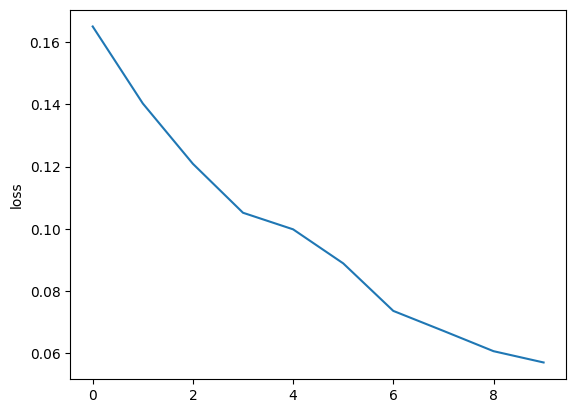

In [ ]:
# - take a look at the evolution of the model loss
plt.plot(loss_progress)
plt.ylabel('loss')
plt.show()
plt.show()

In [ ]:
# - save the best model weights and accuracy.
#   # /!\ This may lead to overfitting: not always the best practice. You can
#   also skip this next line and later save the model weights as they stand after
#   the last iteration.
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [ ]:
# Function to visualize a grid of images
def imshow(inp, title=None):
    """
    Description: This function takes a grid of images and shows them, making
        image visualization easy.
    Parameters:
        `inp`:      type <torch.FloatTensor> object.
        `title`:    type <list> of strings indicating the labels of the `inp`
                        images.
    Output:
        shows the images and their labels (if provided)
    """
    # Convert tensor to numpy array and transpose dimensions
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)  # Clip values to be between 0 and 1 for display
    plt.imshow(inp)  # Display the image
    if title is not None:
        plt.title(title)  # Set the title if provided
    plt.pause(0.001)  # Pause to update the plot

# Function to visualize model predictions
def visualize_model(model, class_names, num_images, dataloaders, use_gpu):
    """
    Description: This function shows N (<num_images>) model predictions (top
        label + top probability).

    Parameters:
        `model`: type <torchvision.models.-modeltype->, the trained model.
        `num_images`: type <int> indicating the number of random images to show.
        `dataloaders`: type <dict> of a 'train' and a 'test
            torch.utils.data.dataloader.DataLoader.
        `use_gpu`: type <bool> indicating whether CUDA is available.

    Output:
        Prints out N predictions
    """
    images_so_far = 0  # Counter for the number of images displayed

    # Iterate over the test dataset
    for i, data in enumerate(dataloaders['test']):
        inputs, labels = data
        # Move data to GPU if available
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()

        # Wrap inputs and labels in Variables
        inputs, labels = Variable(inputs), Variable(labels)

        # Forward pass to get model outputs
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)  # Get the predicted class

        # Iterate over the batch of inputs
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)  # Create a subplot
            ax.axis('off')  # Turn off axis
            ax.set_title(f'predicted: {class_names[preds[j]]}')  # Set the title with the predicted class
            imshow(inputs.cpu().data[j])  # Show the image

            # Stop if we have displayed the required number of images
            if images_so_far == num_images:
                return

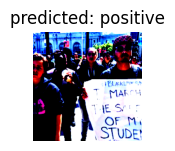

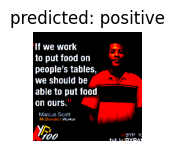

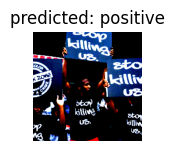

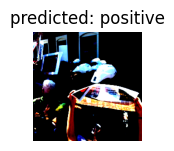

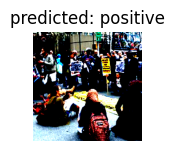

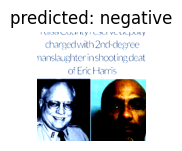

In [ ]:
# - let's use it to check how the model classify some of the images in the test
#   set.
visualize_model(model = model,
                class_names = class_names,
                num_images = 6,
                dataloaders = dataloaders,
                use_gpu = use_gpu)

#### Saving, loading, and using the fine-tuned model


In [ ]:
# - first create an new 'models' subdirectory in your output directory, where
#   we'll save the fine-tuned model

output_path = '/content/gdrive/MyDrive/images-as-data-workshop-elbasan/output/'
output_path02 = '{}/models/'.format(output_path)
if not os.path.isdir(output_path02):
  os.mkdir(output_path02)

In [ ]:
# - PyTorch comes with a function to easily save models
model_filepath = '{}protest-model.pth'.format(output_path02)
torch.save(model, model_filepath)

In [ ]:
# - here is how you can reload the model again
model_new = torch.load(model_filepath, weights_only = False)

In [ ]:
# - using the model for generating predictions

# - load some example images to test how to use, on a "new" set of images, a model
#   you previously trained
pos_path = '{}protest/test/positive/'.format(data_path)
neg_path = '{}protest/test/negative/'.format(data_path)
pos_list = ['{}{}'.format(pos_path, x) for x in os.listdir(pos_path)[:5]]
neg_list = ['{}{}'.format(neg_path, x) for x in os.listdir(neg_path)[:5]]
test_img_path_list = pos_list + neg_list
new_dataset = []
for img_file in test_img_path_list:
    img = Image.open(img_file).convert('RGB')
    new_dataset.append(img)

In [ ]:
len(new_dataset)

10

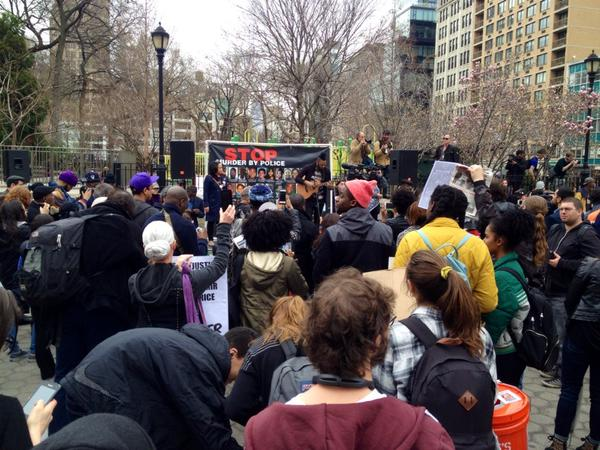

In [ ]:
new_dataset[0]

In [ ]:
# - specifying the transformation-preprocessing to apply to the images
preprocess = data_transform(train = False)

# - checking if the machine has GPUs and enabling GPU computing if so
use_gpu = torch.cuda.is_available()

In [ ]:
# - use the model to perform predictions on this "new" set of images
# ... initialize output dataset and a counter
sigmoid = nn.Sigmoid() # Sigmoid rather than Softmax activation: binary outcome
output_data = pd.DataFrame()
counter = 0
total = len(new_dataset)
# ... iterate through the new images to predict
for z in range(0, len(new_dataset)):
    counter += 1
    print('image: {}/{}'.format(counter, total))
    img_filename = test_img_path_list[z]
    img = new_dataset[z]
    # ... initialize output dict object for this iteration/img
    new_entry = {}
    # ... transform-preprocess this imags
    var = Variable(preprocess(img).unsqueeze(0))
    # ... make the model prediction
    pred = model_new(var.cuda())
    # ... pull the predicted class probabilities and create a dataframe with them
    probs, indeces = sigmoid(pred).cpu().data.sort()
    probs = [round(x, 3) for x in list(probs.numpy()[0])]
    indeces = list(indeces[0][:2])
    labels = [['negative', 'positive'][i] for i in indeces]
    pred_df = pd.DataFrame({'label':labels,
                            'probs':probs})
    pred_df_t = pred_df.transpose()
    final_pred_df = pd.DataFrame(pred_df_t.iloc[1]).transpose()
    final_pred_df.columns = labels
    # ... adding some extra information about the image and prediction
    final_pred_df['img'] = '/'.join(img_filename.split('/')[-2:])
    final_pred_df['max_class'] = ['negative', 'positive'][indeces[1]]
    final_pred_df['max_pr'] = max(probs)
    output_data = pd.concat([output_data, final_pred_df])
output_data = output_data.reset_index(drop=True)

image: 1/10
image: 2/10
image: 3/10
image: 4/10
image: 5/10
image: 6/10
image: 7/10
image: 8/10
image: 9/10
image: 10/10


In [ ]:
output_data

negative positive                 img max_class  max_pr
0    0.131    0.927  positive/37456.jpg  positive   0.927
1    0.244     0.92  positive/42094.jpg  positive   0.920
2    0.273    0.867  positive/50988.jpg  positive   0.867
3    0.273    0.875  positive/42272.jpg  positive   0.875
4    0.329    0.797  positive/44656.jpg  positive   0.797
5    0.635    0.467   negative/9093.jpg  negative   0.635
6    0.608    0.501    negative/335.jpg  negative   0.608
7    0.624    0.401   negative/1477.jpg  negative   0.624
8    0.527    0.587  negative/29986.jpg  positive   0.587
9    0.687    0.251   negative/7358.jpg  negative   0.687

## 6. Fine-tuning multiclass classifier

Use the `world_leaders` dataset we put together to practice fine-tuning for a
multiclass classifier. In this case we have sample face images for 6 world
leaders, most of them not in power anymore, this is from a while back... :)


In [ ]:
# - load a pre-trained model: e.g. Resnet50
model = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')

# - specifying HYPERPARAMETERS (researcher's choice! Some rules of thumb, but
#   usually you should perform a grid search --try many setups-- to see which
#   particular hyperparameter configuration works best)

# - specify the new number of outcome classes: /!\ 6 THIS TIME
num_classes = 6

# - how often do you want the loop to print information about model performance
report_num = 1 # ... every iteration

# - hyperparameters
set_learn_rate = 0.0001 # Enter the desired learning rate
set_momentum = .9 # Enter the desired momentum
set_step_size = 7 # Enter the desired step size
set_gamma = 0.1 # Enter the desired gamma
iter_num = 10 # Enter the desired number of iterations
set_batch_size = 4 # Enter the desired batch size

# - check number of features in last fully connected layer
num_ftrs = model.fc.in_features

# - change the output layer from 1,000 classes to a binary outcome
model.fc = nn.Linear(num_ftrs, num_classes) # For ResNet50, last step is 2048 -> 6

# - specify some additional hyperparameters
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(model.parameters(),
                         lr=set_learn_rate,
                         momentum=set_momentum) # how to perform optimization
scheduler = lr_scheduler.StepLR(optimizer,
                                       step_size=set_step_size,
                                       gamma=set_gamma) # how to update learning rate

# - initialize preprocessing object
preprocess = data_transform()

# - specify the path to data for this particular classifier
model_path = '{}world_leaders/'.format(data_path)

# - specifying where the train and test images are
image_datasets = {x: datasets.ImageFolder(os.path.join(model_path, x),
                                          preprocess[x]) for x in ['train', 'test']}

# - creating an object to easily load the train and test images
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=set_batch_size,
                                             shuffle=True)
              for x in ['train', 'test']}

# - getting some extra information such as the size of the dataset and the
#       class number
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

# - making sure again that we're using GPU. Also, taking the opportunity to check
#   the model architecture and making sure that the "prediction head" has been
#   replaced and is now set up to predict a binary outcome.
use_gpu = True # /!\ Set to False if you run it in a machine with no GPUs
if use_gpu:
  model.cuda()

In [ ]:
# Check the size of the train and test sets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

# Initialize a time object to measure training duration
since = time.time()

# Initialize variables to store the best model weights and accuracy metrics
best_model_wts = model.state_dict()
best_acc = 0.0
best_precision = 0.0
best_recall = 0.0
loss_progress = []
acc_progress = []

# Training loop
for iteration in range(iter_num):
    if iteration % report_num == 0:
        print(f'Iteration {iteration + 1}/{iter_num}')
        print('-' * 10)

    # Each iteration has a training and testing phase
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train(True)  # Set model to training mode
        else:
            model.train(False)  # Set model to evaluation mode

        running_loss = 0.0
        running_corrects = 0
        running_preds = []
        running_labels = []

        # Iterate over data
        for data in dataloaders[phase]:
            inputs, labels = data

            # Move data to GPU if available
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()

            # Wrap inputs and labels in Variables
            inputs, labels = Variable(inputs), Variable(labels)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward propagation
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            # Backward propagation and optimization (only in training phase)
            if phase == 'train':
                loss.backward()
                optimizer.step()  # Update model parameters
                scheduler.step()  # Update learning rate

            # Update running metrics
            running_loss += loss.data
            running_corrects += torch.sum(preds == labels.data)
            running_preds.extend(preds.cpu().numpy())
            running_labels.extend(labels.cpu().numpy())

        # Calculate loss and accuracy for the current phase
        iter_loss = running_loss / dataset_sizes[phase]
        iter_acc = running_corrects.double() / dataset_sizes[phase]

        # Report training progress every report_num iterations
        if iteration % report_num == 0:
            print(f'{phase} Loss: {iter_loss:.4f} Acc: {iter_acc:.4f}')

        # Calculate precision and recall for the test phase
        if phase == 'test':
            iter_precision = precision_score(running_labels, running_preds, average='macro', zero_division=0)
            iter_recall = recall_score(running_labels, running_preds, average='macro', zero_division=0)
            print(f'{phase} Precision: {iter_precision:.4f} Recall: {iter_recall:.4f}\n')

            # Save the best model weights based on accuracy
            if iter_acc > best_acc:
                best_acc = iter_acc
                best_precision = iter_precision
                best_recall = iter_recall
                best_model_wts = model.state_dict()

            # Track the evolution of the loss and accuracy
            loss_progress.append(iter_loss.cpu())
            acc_progress.append(iter_acc.cpu())

    # Early stopping if model reaches good accuracy, precision, and recall
    if best_acc > 0.95 and best_precision > 0.95 and best_recall > 0.95:
        print('... Reached good model accuracy, moving to the next model.')
        break

# Calculate total training time
time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best val Acc: {best_acc:.4f}\n\n')

Iteration 1/10
----------
train Loss: 0.4529 Acc: 0.1875
test Loss: 0.4556 Acc: 0.1833
test Precision: 0.1381 Recall: 0.1833

Iteration 2/10
----------
train Loss: 0.4558 Acc: 0.1458
test Loss: 0.4566 Acc: 0.1667
test Precision: 0.1210 Recall: 0.1667

Iteration 3/10
----------
train Loss: 0.4507 Acc: 0.1792
test Loss: 0.4561 Acc: 0.1500
test Precision: 0.1219 Recall: 0.1500

Iteration 4/10
----------
train Loss: 0.4580 Acc: 0.1625
test Loss: 0.4576 Acc: 0.1500
test Precision: 0.1198 Recall: 0.1500

Iteration 5/10
----------
train Loss: 0.4577 Acc: 0.1500
test Loss: 0.4556 Acc: 0.2000
test Precision: 0.1568 Recall: 0.2000

Iteration 6/10
----------
train Loss: 0.4551 Acc: 0.1583
test Loss: 0.4547 Acc: 0.1500
test Precision: 0.1422 Recall: 0.1500

Iteration 7/10
----------
train Loss: 0.4588 Acc: 0.1417
test Loss: 0.4572 Acc: 0.1667
test Precision: 0.1227 Recall: 0.1667

Iteration 8/10
----------
train Loss: 0.4580 Acc: 0.1625
test Loss: 0.4570 Acc: 0.1833
test Precision: 0.1339 Recall: 

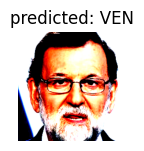

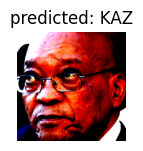

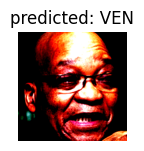

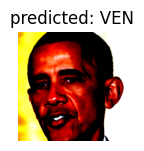

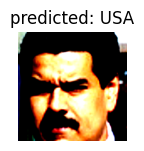

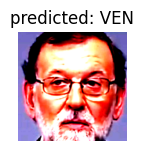

In [ ]:
# - let's also take a look at some of the predictions of this fine-tuned model
visualize_model(model = model,
                class_names = class_names,
                num_images = 6,
                dataloaders = dataloaders,
                use_gpu = use_gpu)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations (you can modify this to match your ResNet preprocessing)
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load your dataset
train_dataset = datasets.ImageFolder(root='/content/gdrive/MyDrive/images-as-data-workshop-gesis/data/world_leaders/train', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.ImageFolder(root='/content/gdrive/MyDrive/images-as-data-workshop-gesis/data/world_leaders/test', transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Load a pretrained Vision Transformer model
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Modify the final layer for your number of classes (6 world leaders)
num_classes = 6
vit_model.head = nn.Linear(vit_model.head.in_features, num_classes)
vit_model = vit_model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
vit_model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = vit_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

# Evaluation
vit_model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vit_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy}%')

Epoch [1/10], Loss: 5.084656998515129
Epoch [2/10], Loss: 2.452293634414673
Epoch [3/10], Loss: 1.8606632947921753
Epoch [4/10], Loss: 1.8650722354650497
Epoch [5/10], Loss: 1.7150647938251495
Epoch [6/10], Loss: 1.786422535777092
Epoch [7/10], Loss: 1.9180802255868912
Epoch [8/10], Loss: 1.8402569144964218
Epoch [9/10], Loss: 1.8710239976644516
Epoch [10/10], Loss: 1.784809723496437
Accuracy: 31.666666666666668%


# Unsupervised Classification

<ins>**Objectives:**</ins>

- **generate image embeddings**: you'll learn how to use a pre-trained CNN for
  generating image embeddings.

- **conduct image clustering**: you'll learn how to use image embeddings for
  clustering images into cohesive groups.

- **evaluate hyperparameters**: you'll learn how to evaluate the effect of some
  key hyperparameters on the output of you unsupervised image classification

<ins>**Datasets:**</ins>

- **protest dataset**: a dataset with sample images of street protests, related
  to BLM protests (and images that are not of protests), that also Nora and I
  put together.


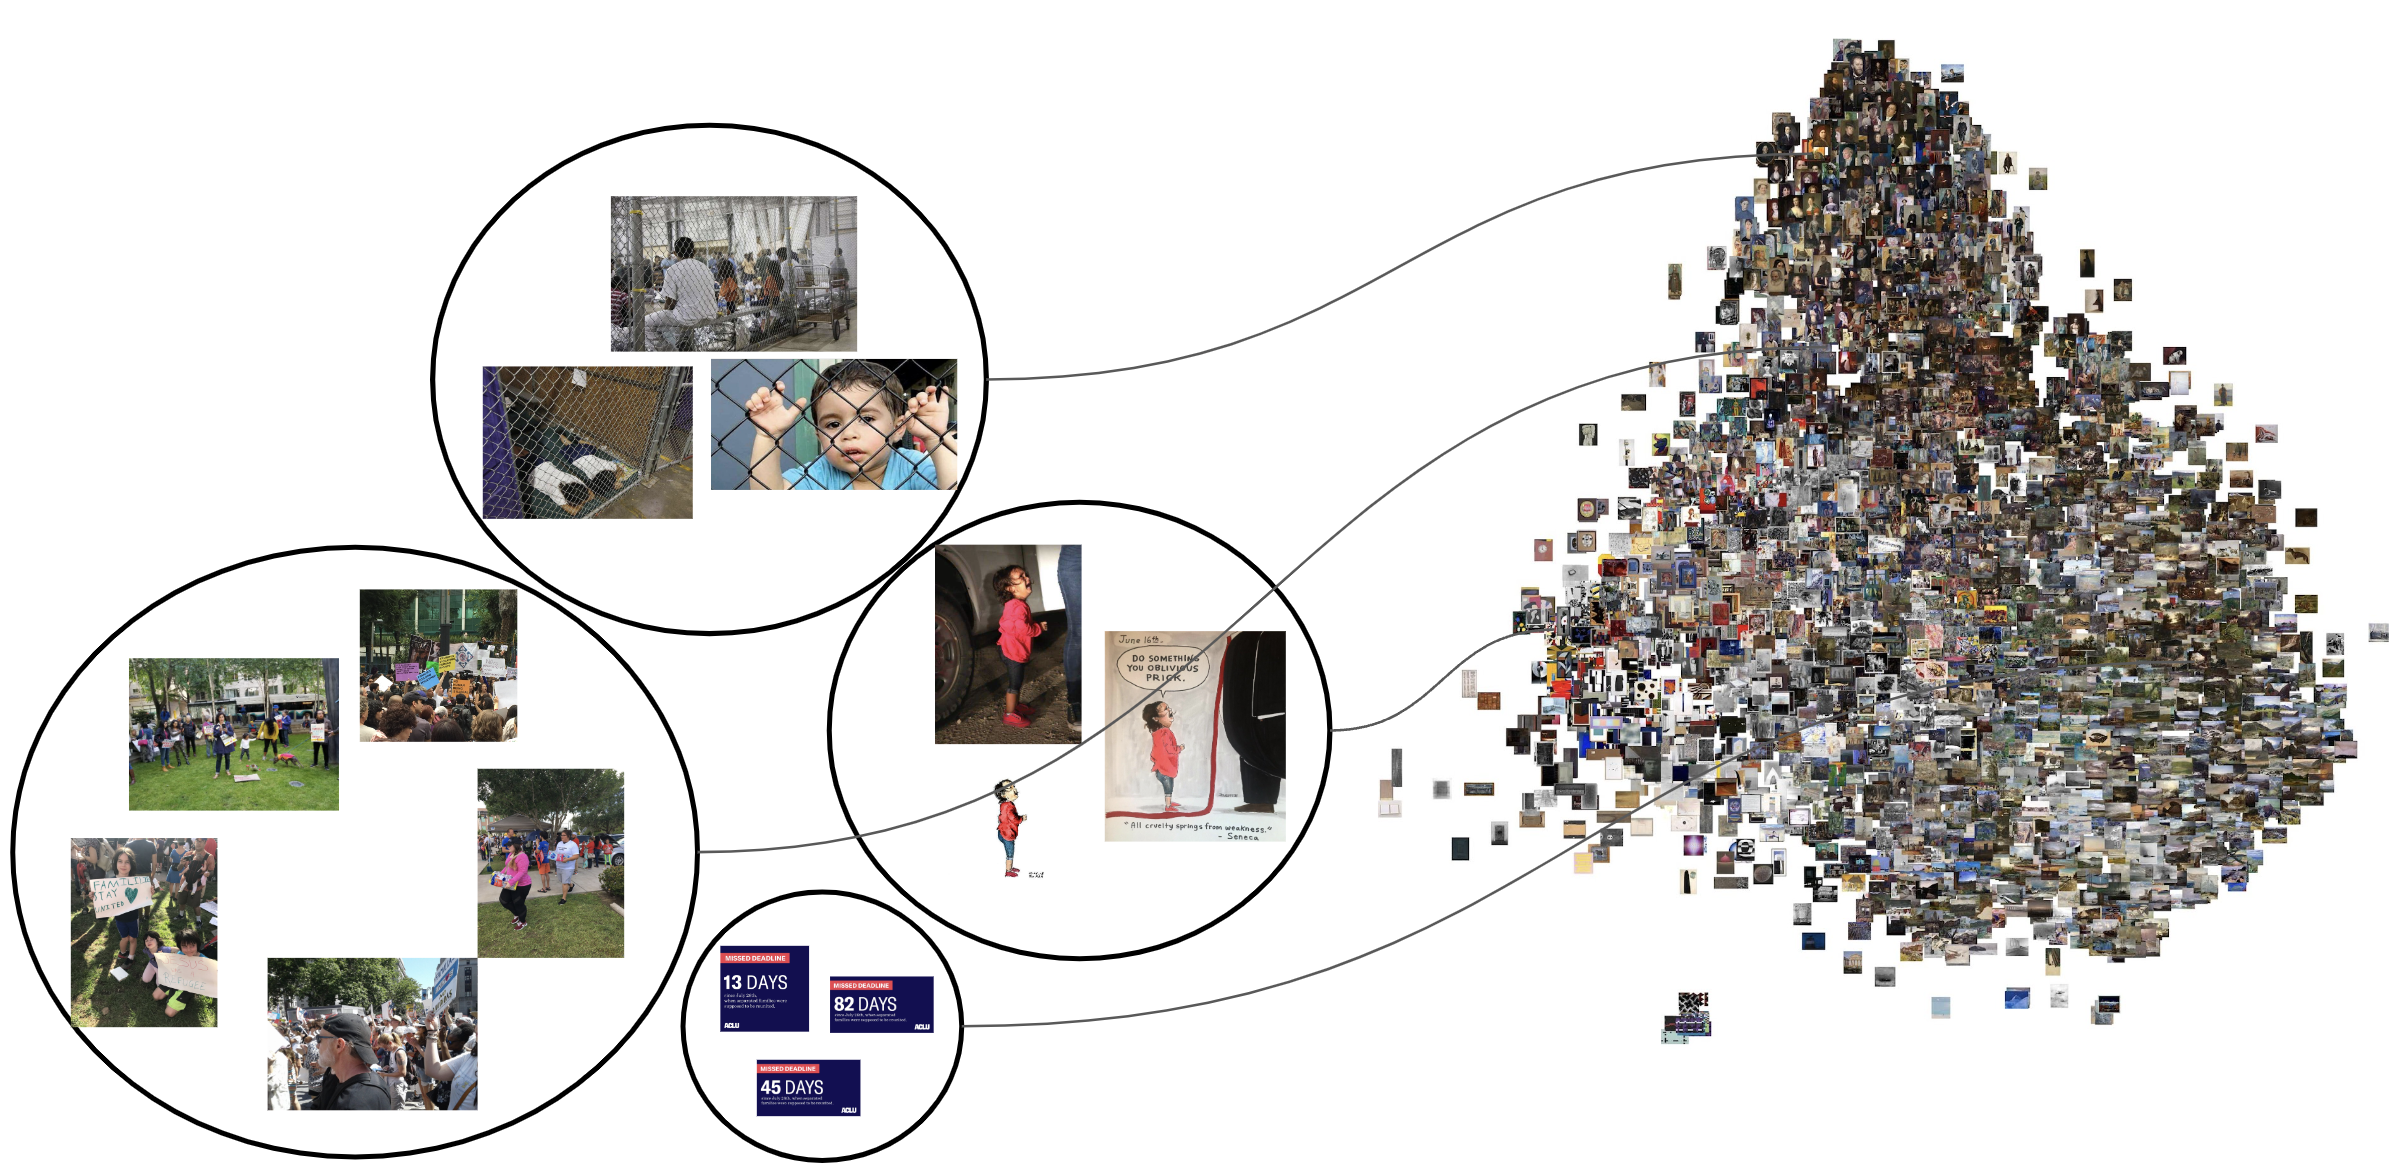


In [ ]:
model

## Drop the last fully-connected layer of the model

This way we can easily pass images through the model, and get the output of the
second-to-last layer. These outputs are dense vector representation of the
images (embeddings), and will be very useful for identifying similar images and
clustering them together


In [ ]:
embed_gen = nn.Sequential(*list(model.children())[:-1])

## 6. Data to be clustered

We'll use the **protest dataset** used in the supervised classification
tutorial. Let's create a list of paths to all the images, so that we can easily
work with them


In [ ]:
# - initialize empty list
imgpaths = []
# - iterate through the 'protest' data folder, and pull the path to the train/test
#   and postitive/negative ones.
protest_path = '{}protest/'.format(data_path)
protest_subdirs = [x for x in os.listdir(protest_path) if '.DS_Store' not in x]
for subdir in protest_subdirs:
  protest_subsubdirs = [x for x in os.listdir('{}{}'.format(protest_path, subdir))
                        if '.DS_Store' not in x]
  for subsubdir in protest_subsubdirs:
    imgfiles = os.listdir('{}{}/{}'.format(protest_path, subdir, subsubdir))
    imgfiles02 = ['{}{}/{}/{}'.format(protest_path, subdir, subsubdir, x)
                  for x in imgfiles if '.jpg' in x]
    imgpaths.extend(imgfiles02)

In [ ]:
len(imgpaths)

In [ ]:
imgpaths[:4]

## 7. Using pre-trained model for generating image embeddings

Now let's used the version of the pre-trained ResNet50 model, for which we've
dropped the last fully-connected layer, to generate image embeddings, by passing
the images trough the model and pulling the vector representation outputed by
that second-to-last layer of the model.

The resulting embeddings will be of size 2048


In [ ]:
# - initialize an empty list where we'll be placing the output embeddings
embed_out = []

# - create a preprocessing object
resnet_preprocess = data_transform(train = False)

# - iterate through the images and generate the two different embeddings
for ipath in tqdm(imgpaths):
  img = Image.open(ipath).convert('RGB')
  img_transformed = Variable(resnet_preprocess(img).unsqueeze(0))
  img_vect_raw = embed_gen(img_transformed.cuda()).data.cpu()
  img_vect = [float(x[0][0]) for x in list(img_vect_raw[0])]
  embed_out.append(img_vect)

## 8. Clustering

- First, we'll create a single matrix with all the image embeddings (200 x 2048)
- Then, we'll use a Kmeans clustering algorithm to cluster the images
- We'll try out different numbers of clusters; and assess which number of
  clusters best fits the data


In [ ]:
# - list of embeddings into a single matrix
embed_mat = np.array(embed_out)

In [ ]:
# - let's take a quick look at the shape of this matrix: 200 (images) X 2048 (size of the embedding)
embed_mat.shape

In [ ]:
# - here how the embedding representation of the first image looks like
embed_out[0]

In [ ]:
# - now let's cluster these image embeddings, every time using a different number
#   of clusters. This is one of the key hyperamaters to take into consideration
k_options = range(2, 60, 2) # any possible even value between 2 and 60,
gof_scores = pd.DataFrame() # an empty data frame where we'll store information about goodnes of fit for each clustering option
counter = 0
for k in tqdm(k_options):
  km = KMeans(n_clusters = k)
  km.fit(embed_mat)
  k_gof = km.score(embed_mat)
  gof_newrow = pd.DataFrame({
      'k':k,
      'gof':k_gof
  }, index = [counter])
  gof_scores = pd.concat((gof_scores, gof_newrow))
  counter += 1

In [ ]:
gof_scores.head()

In [ ]:
# - plot the goodness of fit measure against the number of clusters (k parameter)
sns.lineplot(data=gof_scores, x="k", y="gof")

In [ ]:
# - around 10-20 cluster the increment in terms of goodness of fit only seems to
#   be marginal. To avoid overfitting, let's move forward with e.g. 14 clusters
# - let's then fit this final clustering model with 14 clusters
km = KMeans(n_clusters = 14,
            init='k-means++',
            max_iter=100,
            n_init=1,
            random_state = 1234) # set a random seed for replicability purposes
km.fit(embed_mat)

In [ ]:
# - now let's pull the cluster assignment for each of the 200 images, and store
#   the information in dataframe where we also have information about the path
#   to each image
cl_out = pd.DataFrame({
    'image_path':imgpaths,
    'cluster':km.labels_
})

In [ ]:
# - let's quickly explore how this dataframe looks like
cl_out.head()

## 9. Explore the resulting clusters

- Take a look at the clusters


In [ ]:
# - a function that helps merge images together into a single image, so that
#   we can visualize a set of images together
def show_combined_images(path_list):
  """
  path_list: a list of paths to the image files to be combined into a single one
  """
  images = [Image.open(x) for x in path_list]
  widths, heights = zip(*(i.size for i in images))

  total_width = sum(widths)
  max_height = max(heights)

  new_img = Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    new_img.paste(im, (x_offset,0))
    x_offset += im.size[0]

  return(new_img)

In [ ]:
# - take a quick look at the cluster size distribution
cl_out.groupby(['cluster']).size().reset_index().rename(
    columns = {0:'n'}).sort_values('n', ascending = False)

In [ ]:
# - sample e.g. 5 images from cluster 5
sample5_cl5 = list(cl_out[cl_out['cluster'] == 5].sample(5)['image_path'])

In [ ]:
show_combined_images(sample5_cl5)

In [ ]:
sample5_cl13 = list(cl_out[cl_out['cluster'] == 13].sample(5)['image_path'])
show_combined_images(sample5_cl13)

In [ ]:
# - some of the resulting clusters are more "cohesive" than others. the silhouette
#   scores can help us identify less cohesive clusters (e.g. for further
#   clustering). We can get silhouette scores for each image (provides
#   information about how that image is similar to other images in that cluster,
#   and dissimilar to images in other clusters). I ranges from -1 to 1, where 1
#   means very high within-cluster similarity, and very low across-cluster
#   similarity.
cl_out['sil_score'] = silhouette_samples(embed_mat, km.labels_)

In [ ]:
cl_out.head()

In [ ]:
cl_out.groupby(['cluster']).mean('sil_score').sort_values('sil_score')

In [ ]:
sample5_cl13 = list(cl_out[cl_out['cluster'] == 13].sample(5)['image_path'])
show_combined_images(sample5_cl13)

In [ ]:
sample5_cl10 = list(cl_out[cl_out['cluster'] == 10].sample(5)['image_path'])
show_combined_images(sample5_cl10)

# Multimodal Modeling (Text + Images)

<ins>**Objectives:**</ins>

- **train supervised multimodal models**: you'll learn how to train two
  supervised multimodal (text + image) models: a neural network
  ([CLIP](https://openai.com/index/clip/)) and a Visual Language Model
  ([Idefics2](https://huggingface.co/docs/transformers/main/en/model_doc/idefics2))

<ins>**Data/Datasets:**</ins>

- **interest group twitter dataset**:
  (`ig-tweets-coded-and-translated-balanced-sample-n300.csv`) Toy dataset with
  300 tweets from interest groups from the US, Denmark, and Germany. These
  tweets have been manually annotated for whether they are about lobbying
  (binary). Those about lobbying have been coded for they represent a form of
  direct v. indirect lobbying. And those that aren't about lobbying have also
  been annotated for a set of non-lobbying categories. The dataset is balanced
  across these different target variables and classes.


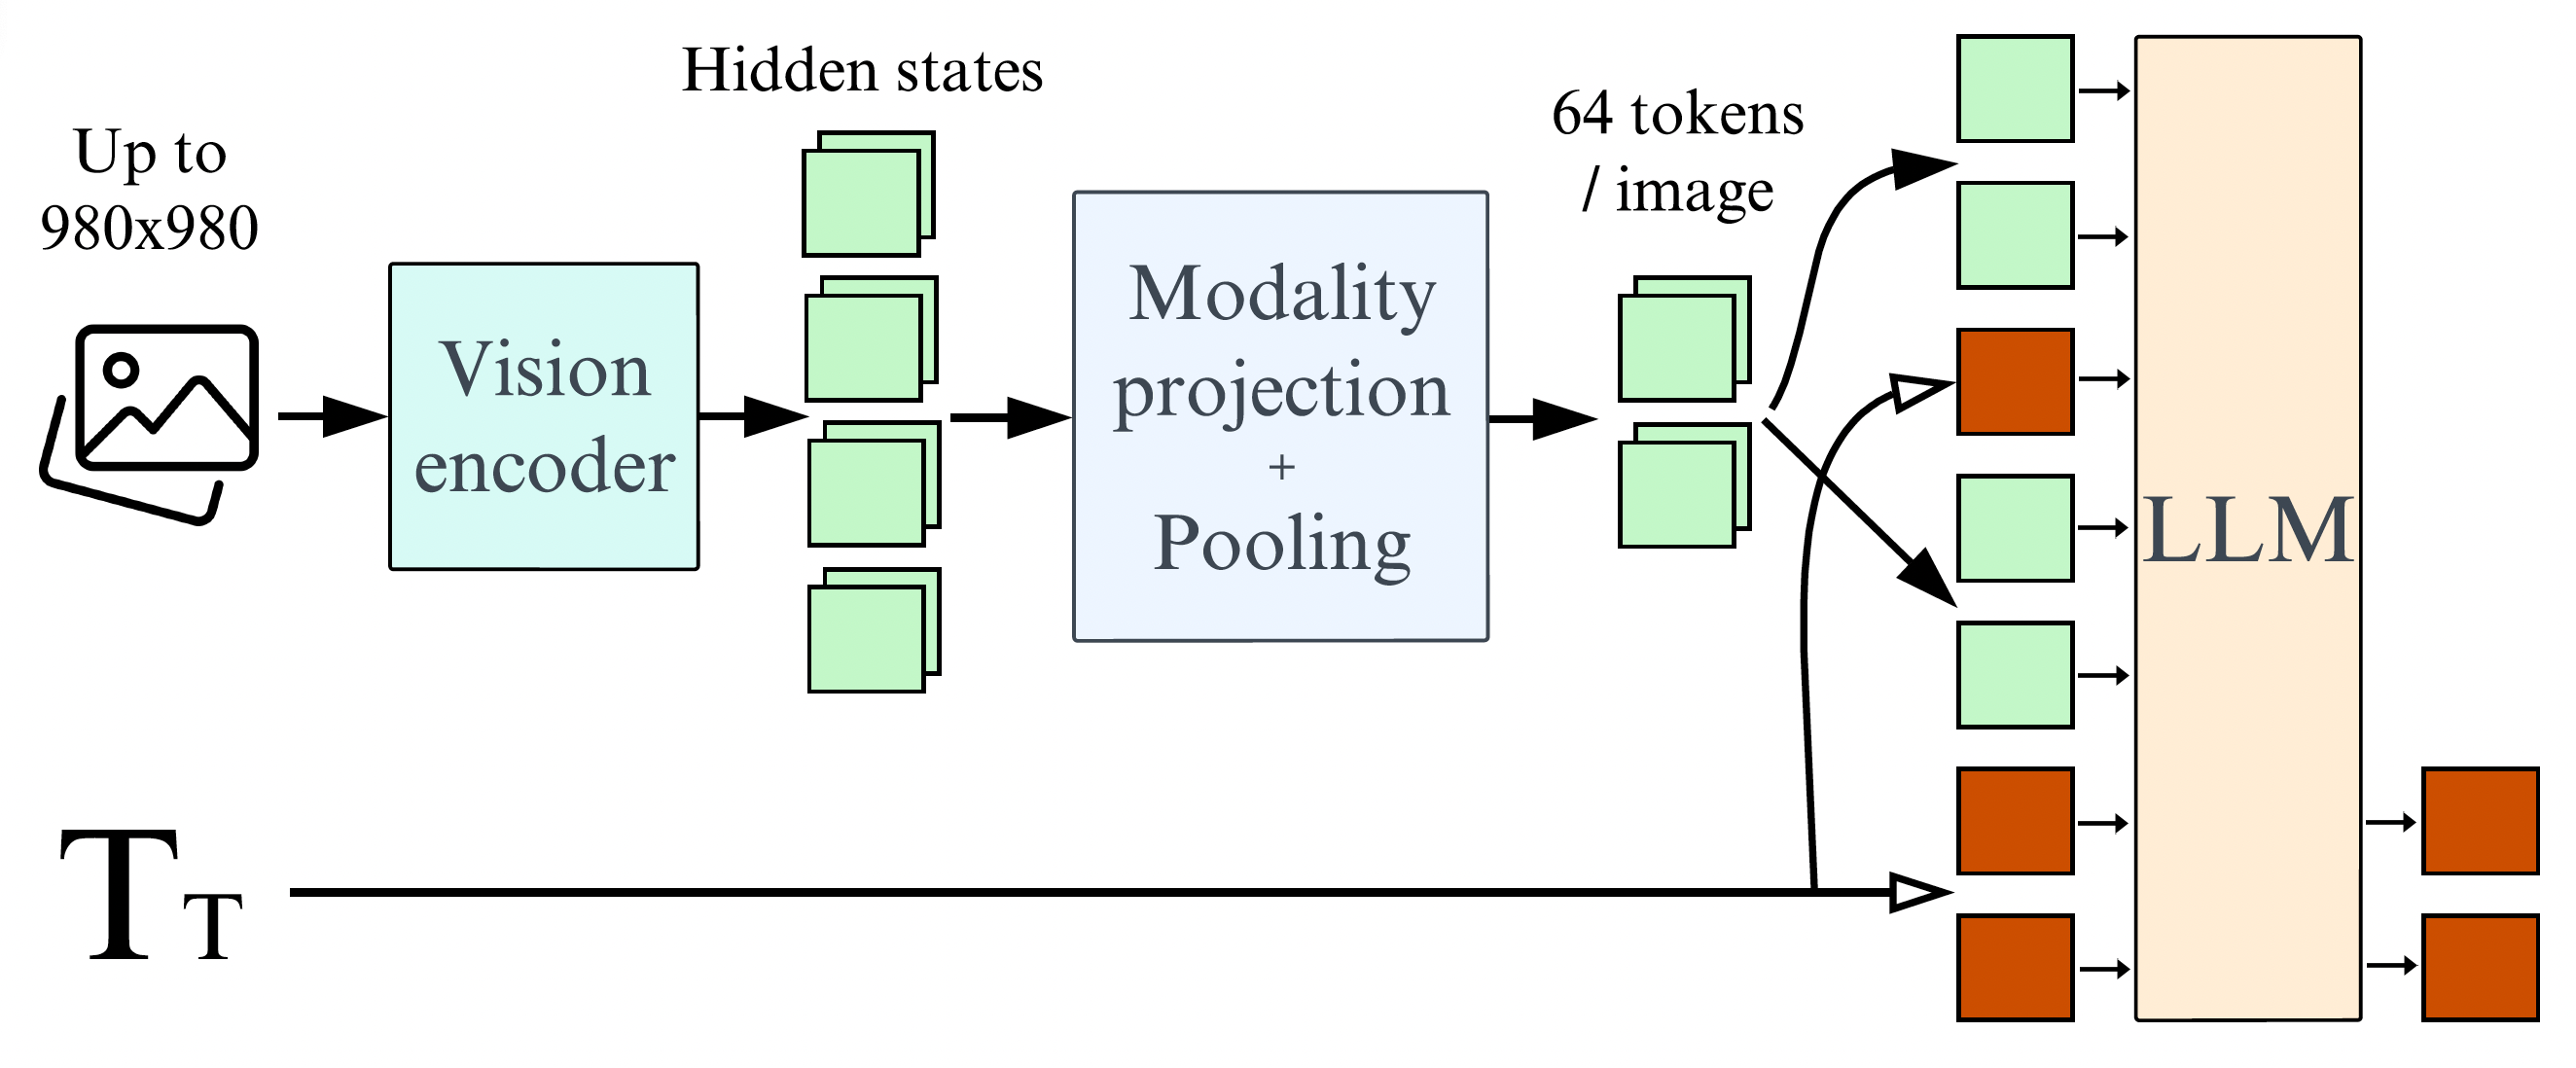


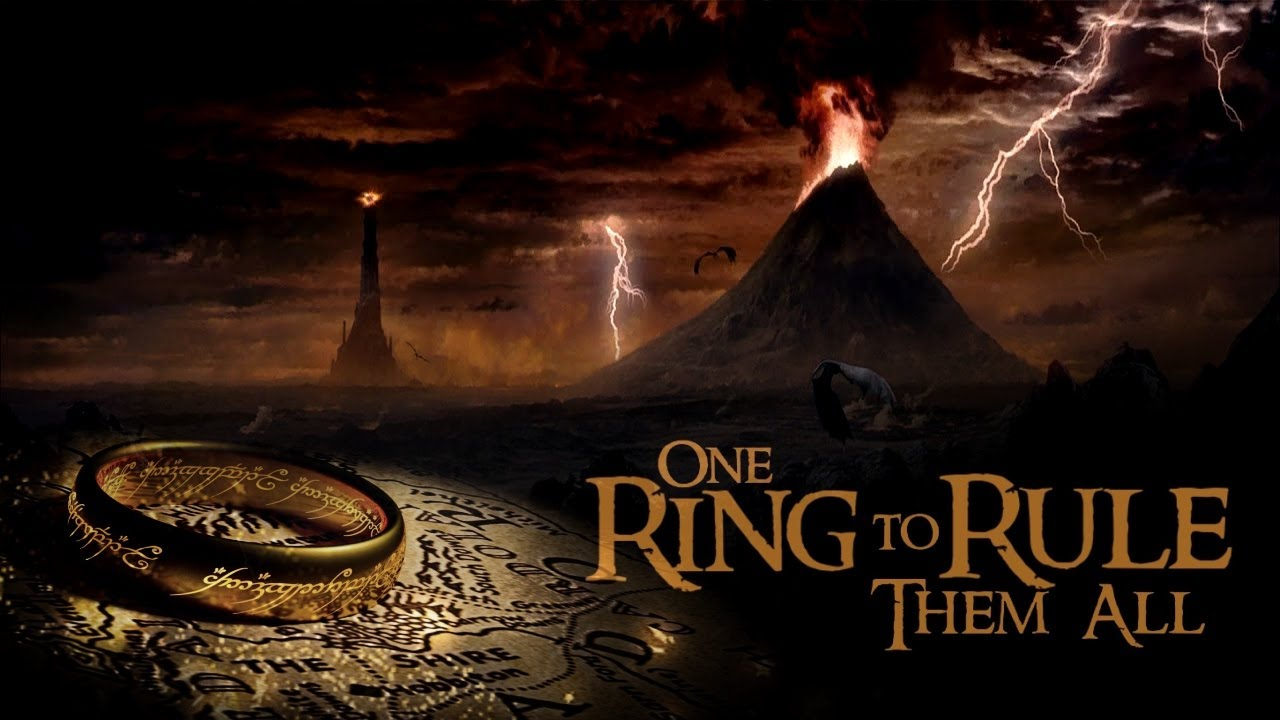


In [ ]:
from transformers import (
    TrainingArguments,
    Trainer,
    AutoModelForVision2Seq,
    Idefics2ForConditionalGeneration,
    AutoProcessor,
    AutoModelForCausalLM,  # AutoModel for language modeling tasks
    AutoTokenizer,  # AutoTokenizer for tokenization
    BitsAndBytesConfig,  # Configuration for BitsAndBytes
    HfArgumentParser,  # Argument parser for Hugging Face models
    TrainingArguments,  # Training arguments for model training
    pipeline,  # Creating pipelines for model inference
    logging,  # Logging information during training
)

In [ ]:
# - set up the data path where the images are located for this workshop
img_path = f'{data_path}ig-300sample/'

In [ ]:
# - load dataset with 300 annotated tweets from interest groups
db = pd.read_csv(
    f'{data_path}ig-tweets-coded-and-translated-balanced-sample-n300.csv',
    dtype = 'str')

In [ ]:
# - take a look at the first couple rows
db.head(2)

In [ ]:
# - save 20% for testing. Set random seed (e.g. to "123"). Use the tweet IDs
#   to keep track about which ones are in the train v. test sets
train_tids, test_tids = train_test_split(list(db['tweet_id']),
                                         test_size = 0.2,
                                         random_state = 123)

## CLIP

How it works, step by step


In [ ]:
# - load clip model and processor
clip_model, clip_preprocess = clip.load("ViT-B/32", "cuda")

In [ ]:
# - let's focus on a single interest group tweet: https://x.com/BPFINews/status/839765117738811393
tweet = db[db['tweet_id'] == "839765117738811393"].iloc[0]
example_text = tweet.text
example_imgname = f'{tweet.user_id}_{tweet.tweet_id}.jpeg'

In [ ]:
print(f'{tweet.tweet_id} from {tweet.org_name}:\n- Text: {example_text}\n- Image filename: {example_imgname}')

In [ ]:
# - load the image
example_img = Image.open(f'{img_path}{example_imgname}').convert("RGB")

In [ ]:
# - tokenize and preprocess text and image
ex_text_ready = clip.tokenize(example_text).to("cuda")
ex_img_ready = clip_preprocess(example_img).unsqueeze(0).to("cuda")

In [ ]:
# - pass them through the CLIP model to get text and image EMBEDDINGS.
ex_img_features = clip_model.encode_image(ex_img_ready).cpu().detach().numpy()
ex_text_features = clip_model.encode_text(ex_text_ready).cpu().detach().numpy()
# - concatenate them to create a joint EMBEDDING
ex_joint_features = np.hstack((ex_img_features, ex_text_features))

In [ ]:
### CLIP: get joint embeddings for the full interest group datasets (300 tweets)

In [ ]:
# - initialize empty feature dataset
all_features = []
all_labels = []
all_tids = []

# - do it in batches, to prevent running out of GPU RAM (VRAM)
batch_size = 4
i_start = 0
i_end = 0

# - iterate through batches of the dataset
batch_counter = 0
total_batches = round(len(db) / batch_size)
while i_start < len(db):
  batch_counter += 1
  print(f'... batch {batch_counter}/{total_batches}')
  if (i_start + batch_size) >= len(db):
    i_end = len(db)
  else:
    i_end += batch_size
  batch = db.iloc[i_start:i_end]

  # - pull key information for this batch from the dataset
  # ... text
  text = list(batch['text_en'])
  # ... tweet ids
  tids = list(batch['tweet_id'])
  all_tids.extend(tids)
  # ... outcome labels
  labels = list(batch['lobbying'])
  # ... making sure the outcome variable is numeric
  labels = [int(x) for x in labels]
  # ... append labels for this batch to the full list of labels for the whole data
  all_labels.extend(labels)

  # ... create image filenames for the images: e.g. "914311278_1234524728393715712.jpeg"
  uids = list(batch['user_id'])
  imgnames = [f'{uids[i]}_{tids[i]}.jpeg' for i in range(len(batch))]

  # - CLIP stuff in here
  # - tokenize text, and use CLIP to generate text embeddings
  text_tokenized = [clip.tokenize(x, truncate = True).to("cuda") for x in text]
  # - generate text embeddings
  text_features = [clip_model.encode_text(x) for x in text_tokenized]
  # - images: load/preprocess/get-embedding
  img_features = []
  for imgname in imgnames:
    # ... loading
    newimg = Image.open(f'{img_path}{imgname}').convert("RGB")
    # ... processing
    newimgproc = clip_preprocess(newimg).unsqueeze(0).to("cuda")
    # ... get embedding
    newimgembed = clip_model.encode_image(newimgproc)
    img_features.append(newimgembed)
  # - concatenate image and text embeddings into a single joined embedding
  joint_features = [
      torch.cat((img_features[i], text_features[i]), dim=1)
      for i in range(len(img_features))
  ]
  # - joined embeddings to numpy format (and bring them back to cpu from gpu)
  features = np.vstack([x.cpu().detach().numpy() for x in joint_features])
  all_features.extend(features)
  # - purge objects that are no longer needed
  del(text_tokenized)
  del(text_features)
  del(img_features)
  del(joint_features)
  del(features)
  torch.cuda.empty_cache()
  # - set up start index for the next batch
  i_start = i_end

In [ ]:
# - transform list of batch-size arrays, into a single array
all_features = np.vstack(all_features)

In [ ]:
# - you could save the matrix of joint embeddings to use it as many times as needed,
#   and not having to get the embeddings again
np.savetxt(f'{data_path}ig-clip-feature-matrix.csv', all_features, delimiter=',')

In [ ]:
clip_mat = np.loadtxt(f'{data_path}ig-clip-feature-matrix.csv',  delimiter=',')

In [ ]:
### CLIP: train ML models predicting `lobbying` target variable, w. CLIP embeddings as input

In [ ]:
# - train/test split
train_inds = [i for i in range(len(all_tids)) if all_tids[i] in train_tids]
test_inds = [i for i in range(len(all_tids)) if all_tids[i] in test_tids]
train_features_clip =  all_features[train_inds]
train_labels = [int(all_labels[i]) for i in train_inds]
test_features_clip = all_features[test_inds]
test_labels = [int(all_labels[i]) for i in test_inds]

In [ ]:
# - 5-fold crossvalidation
performance = []
folds = [123, 321, 789, 648, 204]
fold_n = 0
for fold in folds:
  fold_n += 1
  print(f'Fold {fold_n}/{len(folds)}. Seed {fold}.')
  # - train/validation split
  x_train, x_val, y_train, y_test = train_test_split(
      train_features_clip, train_labels, test_size = 0.2, random_state = fold
  )

  # - TRAIN a set of ML models
  # ... Logistic regression
  logistic_reg = LogisticRegression(random_state=fold, max_iter=1000)
  logistic_reg.fit(train_features_clip, train_labels, )

  # ... 3-layer NN
  nn = MLPClassifier(hidden_layer_sizes = (150,100,50),
                     solver = 'adam',
                     activation = 'relu',
                     learning_rate = 'invscaling',
                     random_state = fold,
                     max_iter = 300)
  nn.fit(train_features_clip, train_labels)

  # - EVALUTE on the TEST set
  logistic_predictions = logistic_reg.predict(test_features_clip)
  logistic_accuracy = round(accuracy_score(test_labels, logistic_predictions) * 100, 1)
  logistic_other = precision_recall_fscore_support(test_labels, logistic_predictions)
  logistic_precision = round(logistic_other[0][1] * 100, 1)
  logistic_recall = round(logistic_other[1][1] * 100, 1)
  logistic_fscore = round(logistic_other[2][1] * 100, 2)
  new_logperf_row = {
    'fold':fold,
    'model':'logistic',
    'accuracy':logistic_accuracy,
    'precision':logistic_precision,
    'recall':logistic_recall,
    'fscore':logistic_fscore
  }
  performance.append(new_logperf_row)

  nn_predictions = nn.predict(test_features_clip)
  nn_accuracy = round(accuracy_score(test_labels, nn_predictions) * 100, 1)
  nn_other = precision_recall_fscore_support(test_labels, nn_predictions)
  nn_precision = round(nn_other[0][1] * 100, 1)
  nn_recall = round(nn_other[1][1] * 100, 1)
  nn_fscore = round(nn_other[2][1] * 100, 2)
  new_nnperf_row = {
    'fold':fold,
    'model':'nn',
    'accuracy':nn_accuracy,
    'precision':nn_precision,
    'recall':nn_recall,
    'fscore':nn_fscore
  }
  performance.append(new_nnperf_row)

  # - report performance
  print(r'... logistic regression:')
  print(f'\t accuracy = {logistic_accuracy}')
  print(f'\t precision = {logistic_precision}')
  print(f'\t recall = {logistic_recall}')
  print(f'\t fscore = {logistic_fscore}')

  print(r'... 2-layer NN:')
  print(f'\t accuracy = {nn_accuracy}')
  print(f'\t precision = {nn_precision}')
  print(f'\t recall = {nn_recall}')
  print(f'\t fscore = {nn_fscore}')
  print('\n')

In [ ]:
# - calculate 3-fold crossvalidation for each classifier
performance_df = pd.DataFrame(performance)

In [ ]:
performance_df.groupby(['model']).agg({'accuracy': 'mean', 'precision':'mean', 'recall':'mean', 'fscore':'mean'})

In [ ]:
## Idefics2

In [ ]:
model_name = "HuggingFaceM4/idefics2-8b"
compute_dtype = getattr(torch, "float16")
DEVICE = "cuda:0"

In [ ]:
bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )

In [ ]:
# - load image processor for Idefics2
processor = AutoProcessor.from_pretrained(model_name, do_image_splitting = False)

In [ ]:
# - load text tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# - specify the quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)

In [ ]:
# - load the Idefics2 model. It will take a while to download all model weights.
#   /!\ VERY BIG model: ~ 35GB. You need to make sure you have space for it! /!\
model = Idefics2ForConditionalGeneration.from_pretrained(
            "HuggingFaceM4/idefics2-8b",
            torch_dtype=torch.float16,
            quantization_config=bnb_config,
            #cache_dir = cache_dir
        )

In [ ]:
# - let's use the same single example: https://x.com/BPFINews/status/839765117738811393
tweet = db[db['tweet_id'] == "839765117738811393"].iloc[0]
example_text = tweet.text
example_imgname = f'{tweet.user_id}_{tweet.tweet_id}.jpeg'

In [ ]:
print(f'{tweet.tweet_id} from {tweet.org_name}:\n- Text: {example_text}\n- Image filename: {example_imgname}')

In [ ]:
# - define the message/question we want to ask
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "You'll be shown an image included in a tweet."},
            #{"type": "text", "text": f"Here is the text of a tweets from an interest group: '{example_text}'. Next you can see the image included in the tweet."},
            {"type": "image"},
            {"type": "text", "text": "Please describe the image"},
            #{"type": "text", "text": "How many people do you see in the image?"},
            #{"type": "text", "text": "Your job is to code it for whether it performs direct lobbying. Consider the tweet to perform direct lobbying if it mentions any of the following: * a political, judicial, or administrative institution, like the parliament, administration, congress, senate, government, municipal council, regional council, ministry, department, cabinet, and regional or state authority * politicians who may be referred to by their names and/or positions, like president, senator, mayor, congressman, politician, deputy, MP, representative, parliamentarian, minister, party leader, government official, lawmaker etc. * court cases or legal actions. The tweet should not be considered performing direct lobbying if it explicitly supports or calls for political actions like protests, marches, rallies, strikes, demonstrations, petitions, consultations, and public comments. Return Yes if the tweet performs direct lobbying, No otherwise. It is essential that you give a one-word yes/no answer."}
            ]
        }
]

In [ ]:
# - process the text in the message
text = processor.apply_chat_template(messages, add_generation_prompt=False)

In [ ]:
# - define the image/s to include in the prompt/message
image = [example_img]

In [ ]:
# - process/tokenize images/text
inputs = processor(text=text, images=image, return_tensors="pt", padding=True)

In [ ]:
# - send input to GPU, where the model is located
inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

In [ ]:
# - run the inputs through the model
generated_ids = model.generate(**inputs, max_new_tokens=500)

# - transform the tokenized id responses into actual text
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

In [ ]:
# - take a look at the generated text
generated_texts

### Idefics2: zero-shot classification


In [ ]:
# - train/test split
all_tids = list(db['tweet_id'])
all_labels = list(db['lobbying'])
train_inds = [i for i in range(len(all_tids)) if all_tids[i] in train_tids]
test_inds = [i for i in range(len(all_tids)) if all_tids[i] in test_tids]
train_labels = [int(all_labels[i]) for i in train_inds]
test_labels = [int(all_labels[i]) for i in test_inds]

In [ ]:
train_db = db.iloc[train_inds]
test_db = db.iloc[test_inds]

In [ ]:
train_labels = [int(x) for x in list(train_db['lobbying'])]
test_labels = [int(x) for x in list(test_db['lobbying'])]

In [ ]:
# - the coding instructions text
instruction = "Your job is to code it for whether it performs direct lobbying. Consider it as performing direct lobbying if it mentions: * a political, judicial, or administrative institution, like the parliament, administration, congress, senate * politicians who may be referred to by their names or positions, like president or congressman * court cases or legal actions. It should not be considered as direct lobbying if it supports or calls for political actions like protests, petitions, consultations, and public comments. Return YES if the tweet performs direct lobbying, NO otherwise."

In [ ]:
# - initialize empty lists to keep track of actual v. predicted labels for the
#   tweets in the test set
actual = []
preds = []

# - iterate through tweets in the test set
for i in tqdm(range(len(test_db))):
    #i = 2 # /!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\
    tweet = test_db.iloc[i]
    tweet_id = tweet.tweet_id
    user_id = tweet.user_id
    tweet_text = tweet.text_en
    # ... add apostrophes to the text
    tweet_text = re.sub('\[a\]', "'", tweet_text)
    # ... get rid of links: they take uncessary space/tokens
    tweet_text = ' '.join(re.sub(r"http\S+", "", tweet_text).split())
    label = tweet.lobbying
    # - path to the image included in this tweet
    tweet_imgname = f'{img_path}{user_id}_{tweet_id}.jpeg'
    # - load the image
    tweet_img = Image.open(tweet_imgname).convert("RGB")
    # - define the message/question we want to ask
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": f"Here is a tweets from an interest group: '{tweet_text}', and here the included image:"},
                {"type": "image"},
                {"type": "text", "text": instruction}
                ]
            }
    ]
    # - process message, pass through model, and get answer
    text = processor.apply_chat_template(messages, add_generation_prompt=False)
    # - process/tokenize images/text
    inputs = processor(text=text, images=[tweet_img], return_tensors="pt", padding=True)
    # - send input to GPU, where the model is located
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    # - run the inputs through the model
    generated_ids = model.generate(**inputs, max_new_tokens=500)
    # - transform the tokenized id responses into actual text
    generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)
    # - extract Yes or No from response
    last_chars = generated_texts[0][-5:]
    if 'no' in last_chars.lower():
        out = '0'
    elif 'yes' in last_chars.lower():
        out = '1'
    else:
        if 'does not perform direct lobbying' in generated_texts:
            out = '0'
        else:
            out = None
    preds.append(out)
    actual.append(label)

In [ ]:
# - let's look at the performance, for this task, at zero shot
print(f'N actual lobbying = {sum([int(x) for x in actual])}')
print(f'N predicted lobbying = {sum([int(x) for x in preds])}')
print(f'Accuracy: {round(accuracy_score(actual, preds) * 100, 1)}%')
print(f'Precision: {round(precision_recall_fscore_support(actual, preds)[0][1] * 100, 1)}%')
print(f'Recall: {round(precision_recall_fscore_support(actual, preds)[1][1] * 100, 1)}%')
print(f'Fscore: {round(precision_recall_fscore_support(actual, preds)[2][1] * 100, 1)}%')

In [ ]:
### Idefics2: fine-tuning it for our own task

In [ ]:
# - a data collator function, for better data managing/batching for fine-tunign idefics2
#   Source: https://colab.research.google.com/drive/1rm3AGquGEYXfeeizE40bbDtcWh5S4Nlq?usp=sharing#scrollTo=yePZRNBTK0Ux
class MyDataCollator:
    '''
    This is a data collator class which is used to process data for fine-tuning Idefics2
    '''
    def __init__(self, processor):
        self.processor = processor
        self.image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")
        ]

    def __call__(self, examples):
        texts = []
        images = []
        for example in examples:
            image_path = example["image"]
            # Check if the image path is valid
            if not os.path.exists(image_path):
                print(f"Warning: Image path {image_path} does not exist.")
                continue

            try:
                image = Image.open(image_path)
            except Exception as e:
                print(f"Error opening image {image_path}: {e}")
                continue

            question = example["query"]
            answer = random.choice(example["answers"])
            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "image"},
                        {"type": "text", "text": question}
                    ]
                },
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": answer}
                    ]
                }
            ]
            text = self.processor.apply_chat_template(messages, add_generation_prompt=False)
            texts.append(text.strip())
            images.append([image])

        if not texts or not images:
            raise ValueError("No valid examples to process.")

        batch = self.processor(text=texts, images=images, return_tensors="pt", padding=True)
        labels = batch["input_ids"].clone()
        labels[labels == self.processor.tokenizer.pad_token_id] = self.image_token_id
        batch["labels"] = labels
        return batch

In [ ]:
# - initialize again the model, processor, tokenizer, quantization object, etc.
model_name = "HuggingFaceM4/idefics2-8b"

processor = AutoProcessor.from_pretrained(
    model_name,
    do_image_splitting=False
)

data_collator = MyDataCollator(processor)

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
DEVICE = "cuda:0"
USE_LORA = False
USE_QLORA = True

# Three options for training, from the lowest precision training to the highest precision training:
# - QLora
# - Standard Lora
# - Full fine-tuning
if USE_QLORA or USE_LORA:
    lora_config = LoraConfig(
        r=8,
        lora_alpha=8,
        lora_dropout=0.1,
        target_modules='.*(text_model|modality_projection|perceiver_resampler).*(down_proj|gate_proj|up_proj|k_proj|q_proj|v_proj|o_proj).*$',
        use_dora=False if USE_QLORA else True,
        init_lora_weights="gaussian"
    )
    if USE_QLORA:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )
    model = Idefics2ForConditionalGeneration.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        quantization_config=bnb_config if USE_QLORA else None,
        #cache_dir = cache_dir
    )
    model.add_adapter(lora_config)
    model.enable_adapters()
else:
    model = Idefics2ForConditionalGeneration.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        _attn_implementation="flash_attention_2", # Only available on A100 or H100
    ).to(DEVICE)

In [ ]:
performance_ft = pd.DataFrame()
folds = [123, 321, 789, 648, 204]
fold_n = 0
#for fold in folds:
fold = folds[1] # /!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!d\/!\
fold_n += 1
print(f'Fold {fold_n}/{len(folds)}. Seed {fold}.')
# - train/validation split
t_db, v_db = train_test_split(
  train_db, test_size = 0.2, random_state = fold
)
# - transform data in the TRAIN set
train_data = []
for i in range(len(t_db)):
    t_tweet = t_db.iloc[i]
    t_text = t_tweet.text_en
    t_text = re.sub('\[a\]', "'", t_text)
    t_text = ' '.join(re.sub(r"http\S+", "", t_text).split())
    t_tid = t_tweet.tweet_id
    t_uid = t_tweet.user_id
    t_label = t_tweet.lobbying
    t_imgname = f'{img_path}{t_uid}_{t_tid}.jpeg'
    #t_img = Image.open(t_imgname).convert('RGB')
    if t_label == "1":
        t_out = "YES"
    else:
        t_out = "NO"
    new_data_train = {
        'id':t_tid,
        'image':t_imgname,
        'query':f"Here is a tweet from an interest group and the attached image: ''{t_text}''. {instruction}",
        'answers':[t_out]
    }
    train_data.append(new_data_train)

# - transform data in the VALIDATION set
val_data = []
for i in range(len(v_db)):
    v_tweet = v_db.iloc[i]
    v_text = v_tweet.text_en
    v_text = re.sub('\[a\]', "'", v_text)
    v_text = ' '.join(re.sub(r"http\S+", "", v_text).split())
    v_tid = v_tweet.tweet_id
    v_uid = v_tweet.user_id
    v_label = v_tweet.lobbying
    v_imgname = f'{img_path}{v_uid}_{v_tid}.jpeg'
    #v_img = Image.open(v_imgname).convert('RGB')
    if v_label == "1":
        v_out = "YES"
    else:
        v_out = "NO"
    new_data_val = {
        'id':v_tid,
        'image':v_imgname,
        'query':f"Here is a tweet from an interest group and the attached image: ''{v_text}''. {instruction}",
        'answers':[v_out]
    }
    val_data.append(new_data_val)

# - data into pandas dataframe, and then into huggingface dataset format
train_df = pd.DataFrame(train_data).reset_index(drop=True)
val_df = pd.DataFrame(val_data).reset_index(drop=True)

# Convert the DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

train_dataset = dataset
eval_dataset = val_dataset

# - specify training arguments
training_args = TrainingArguments(
            num_train_epochs=1,
            per_device_train_batch_size=1,
            per_device_eval_batch_size=2,
            gradient_accumulation_steps=1,
            eval_strategy="epoch",
            do_eval=True,
            optim="paged_adamw_32bit",
            warmup_steps=50,
            learning_rate=0.00005,
            weight_decay=0.01,
            logging_steps=25,
            save_strategy="steps",
            save_steps=10000,
            save_total_limit=1,
            output_dir = out_dir,
            fp16=True,
            remove_unused_columns=False,
            lr_scheduler_type="linear",
            report_to="none",
        )

# - initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
)

epochs = 10
for epoch in range(epochs):
    print(f'Fold {epoch + 1}/{epochs}\n\n')
    trainer.train()
    train_loss = trainer.state.log_history[-1]['train_loss']
    eval_loss = trainer.state.log_history[-2]['eval_loss']

    # - record train loss
    train_performance_row = pd.DataFrame({
        'fold':fold,
        'epoch':epoch,
        'type':'train',
        'accuracy':None,
        'precision':None,
        'recall':None,
        'fscore':None,
        'loss':train_loss,
    }, index = [0])
    performance_ft = pd.concat((performance_ft, train_performance_row))

    # - get precision, recall, fscore for the TEST SET
    val_actual = []
    val_preds = []

    # - iterate through tweets in the test set
    for i in tqdm(range(len(v_db))):
        #i = 2 # /!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\
        tweet = v_db.iloc[i]
        tweet_id = tweet.tweet_id
        user_id = tweet.user_id
        tweet_text = tweet.text_en
        # ... add apostrophes to the text
        tweet_text = re.sub('\[a\]', "'", tweet_text)
        # ... get rid of links: they take uncessary space/tokens
        tweet_text = ' '.join(re.sub(r"http\S+", "", tweet_text).split())
        label = tweet.lobbying
        # - path to the image included in this tweet
        tweet_imgname = f'{img_path}{user_id}_{tweet_id}.jpeg'
        # - load the image
        tweet_img = Image.open(tweet_imgname).convert("RGB")
        # - define the message/question we want to ask
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": f"Here is a tweet from an interest group and the attached image: ''{v_text}''. {instruction}"},
                    {"type": "image"}
                    ]
                }
        ]
        # - process message, pass through model, and get answer
        text = processor.apply_chat_template(messages, add_generation_prompt=False)
        # - process/tokenize images/text
        inputs = processor(text=text, images=[tweet_img], return_tensors="pt", padding=True)
        # - send input to GPU, where the model is located
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        # - run the inputs through the model
        generated_ids = model.generate(**inputs, max_new_tokens=500)
        # - transform the tokenized id responses into actual text
        generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)
        # - extract Yes or No from response
        last_chars = generated_texts[0][-5:]
        if 'no' in last_chars.lower():
            out = '0'
        elif 'yes' in last_chars.lower():
            out = '1'
        else:
            if 'does not perform direct lobbying' in generated_texts:
                out = '0'
            else:
                out = None
        val_preds.append(out)
        val_actual.append(label)


    # - let's look at TEST performance
    print('VALIDATION performance')
    # ... count/remove Nones
    val_nones_i = [i for i in range(len(val_preds)) if val_preds[i] is None]
    if len(val_nones_i) > 0:
        print(f'\t {len(val_nones_i)} None')
        val_preds = [val_preds[i] for i in range(len(val_preds)) if i not in val_nones_i]
        val_actual = [val_actual[i] for i in range(len(val_actual)) if i not in val_nones_i]
    val_accuracy = round(accuracy_score(val_actual, val_preds) * 100, 1)
    val_precision = round(precision_recall_fscore_support(val_actual, val_preds)[0][1] * 100, 1)
    val_recall = round(precision_recall_fscore_support(val_actual, val_preds)[1][1] * 100, 1)
    val_fscore = round(precision_recall_fscore_support(val_actual, val_preds)[2][1] * 100, 1)
    print(f'N actual lobbying = {sum([int(x) for x in val_actual])}')
    print(f'N predicted lobbying = {sum([int(x) for x in val_preds])}')
    print(f'Accuracy: {val_accuracy}%')
    print(f'Precision: {val_precision}%')
    print(f'Recall: {val_recall}%')
    print(f'Fscore: {val_fscore}%')
    print('\n')
    val_performance_row = pd.DataFrame({
        'fold':fold,
        'epoch':epoch,
        'type':'validation',
        'accuracy':val_accuracy,
        'precision':val_precision,
        'recall':val_recall,
        'fscore':val_fscore,
        'loss':eval_loss,
    }, index = [0])
    performance_ft = pd.concat((performance_ft, val_performance_row))

    # - get precision, recall, fscore for the TEST SET
    test_actual = []
    test_preds = []

    # - iterate through tweets in the test set
    for i in tqdm(range(len(test_db))):
        #i = 2 # /!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\
        tweet = test_db.iloc[i]
        tweet_id = tweet.tweet_id
        user_id = tweet.user_id
        tweet_text = tweet.text_en
        # ... add apostrophes to the text
        tweet_text = re.sub('\[a\]', "'", tweet_text)
        # ... get rid of links: they take uncessary space/tokens
        tweet_text = ' '.join(re.sub(r"http\S+", "", tweet_text).split())
        label = tweet.lobbying
        # - path to the image included in this tweet
        tweet_imgname = f'{img_path}{user_id}_{tweet_id}.jpeg'
        # - load the image
        tweet_img = Image.open(tweet_imgname).convert("RGB")
        # - define the message/question we want to ask
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": f"Here is a tweet from an interest group and the attached image: ''{tweet_text}''. {instruction}"},
                    {"type": "image"}
                    ]
                }
        ]
        # - process message, pass through model, and get answer
        text = processor.apply_chat_template(messages, add_generation_prompt=False)
        # - process/tokenize images/text
        inputs = processor(text=text, images=[tweet_img], return_tensors="pt", padding=True)
        # - send input to GPU, where the model is located
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        # - run the inputs through the model
        generated_ids = model.generate(**inputs, max_new_tokens=500)
        # - transform the tokenized id responses into actual text
        generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)
        # - extract Yes or No from response
        last_chars = generated_texts[0][-5:]
        if 'no' in last_chars.lower():
            out = '0'
        elif 'yes' in last_chars.lower():
            out = '1'
        else:
            if 'does not perform direct lobbying' in generated_texts:
                out = '0'
            else:
                out = None
        test_preds.append(out)
        test_actual.append(label)

    # - let's look at TEST performance
    print('TEST performance')
    test_nones_i = [i for i in range(len(test_preds)) if test_preds[i] is None]
    if len(test_nones_i) > 0:
        print(f'\t {len(test_nones_i)} None')
        test_preds = [test_preds[i] for i in range(len(test_preds)) if i not in test_nones_i]
        test_actual = [test_actual[i] for i in range(len(test_actual)) if i not in test_nones_i]
    test_accuracy = round(accuracy_score(test_actual, test_preds) * 100, 1)
    test_precision = round(precision_recall_fscore_support(test_actual, test_preds)[0][1] * 100, 1)
    test_recall = round(precision_recall_fscore_support(test_actual, test_preds)[1][1] * 100, 1)
    test_fscore = round(precision_recall_fscore_support(test_actual, test_preds)[2][1] * 100, 1)
    print(f'N actual lobbying = {sum([int(x) for x in test_actual])}')
    print(f'N predicted lobbying = {sum([int(x) for x in test_preds])}')
    print(f'Accuracy: {test_accuracy}%')
    print(f'Precision: {test_precision}%')
    print(f'Recall: {test_recall}%')
    print(f'Fscore: {test_fscore}%')
    print('\n')
    print('\n')
    print('\n')
    test_performance_row = pd.DataFrame({
        'fold':fold,
        'epoch':epoch,
        'type':'test',
        'accuracy':test_accuracy,
        'precision':test_precision,
        'recall':test_recall,
        'fscore':test_fscore,
        'loss':None,
    }, index = [0])
    performance_ft = pd.concat((performance_ft, test_performance_row))

In [ ]:
# - save the output
performance_ft.to_csv(f'{out_dir}idefics2-finetuned-lobbying-example.csv', index = False)

In [ ]:
# - save the output
performance_ft.to_csv(f'{out_dir}idefics2-finetuned-lobbying-example.csv', index = False)

In [ ]:
performance_ft

In [ ]:
# - best test performance (based on fscore)
val_perf = performance_ft[performance_ft['type'] == 'validation']
best_val_epoch = val_perf[val_perf['fscore'] == max(val_perf['fscore'])]['epoch'].iloc[0]
performance_ft[(performance_ft['type'] == 'test') &
               (performance_ft['epoch'] == best_val_epoch)]

In [ ]:
# - CLIP performances for comparison
#        accuracy precision	recall	fscore
# model
# logistic	75.00	81.80	62.10	70.59
# nn	      75.68	80.98	64.82	71.92